In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## TCGA

## FPKM (Fragments Per Kilobase of transcript per Million)

When you have paired-end RNA-seq data, you count **fragments** (read pairs) rather than individual reads. FPKM normalizes for sequencing depth and gene length just like RPKM, but uses fragments.

1. **Sequencing depth**: samples sequenced to different depths get scaled so total fragment count differences don’t bias comparisons.  
2. **Gene length**: longer transcripts produce more fragments just by being longer, so we divide out transcript length.

The normalized \((i, j)\) FPKM value, where \(i\) is a gene and \(j\) is a sample, can be written two ways:

$$
\mathrm{FPKM}_{i,j}
=
\frac{f_{i,j}}
     {\,l_i \cdot \sum_{k} f_{k,j}\,}
\times 10^6
$$

or equivalently

$$
\mathrm{FPKM}_{i,j}
=
\frac{f_{i,j} \;\times\; 10^9}
     {\,N_j \;\times\; L_i\,}
$$

<!-- blank line above is important -->
- **$f_{i,j}$** is the raw fragment count for gene \(i\) in sample \(j\).  
- **$l_i$** is the length of gene \(i\) in kilobases (kb).  
- **$\sum_{k} f_{k,j}$** is the total number of fragments in sample \(j\).  
- **$N_j$** is the total fragments sequenced in sample \(j\).  
- **$L_i$** is the length of gene \(i\) in bases.  


In [3]:
# mRNA seq
# Expression Data with gene as index and cells/samples as columns
data_mrna_seq_rpkm = pd.read_csv('tcga_data/data_mrna_seq_fpkm.txt',
                    sep = '\t',
                    comment = '#')

data_mrna_seq_rpkm.set_index('Hugo_Symbol',inplace=True)
print(f"Shape before merging duplicated rows: {data_mrna_seq_rpkm.shape}")

# Merge with mean duplicated rows
data_mrna_seq_rpkm = data_mrna_seq_rpkm.groupby(data_mrna_seq_rpkm.index).mean()
print(f"Shape after merging duplicated rows: {data_mrna_seq_rpkm.shape}")

Shape before merging duplicated rows: (55921, 1210)
Shape after merging duplicated rows: (55851, 1210)


In [4]:
data_mrna_seq_rpkm.head()

,SP89389,SP21193,SP13206,SP103623,SP32742,SP111095,SP8394,SP87446,SP36586,SP123902,...,SP15656,SP123888,SP59420,SP116679,SP1377,SP16269,SP122676,SP88776,SP64546,SP21057
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
CRIPTOP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1BG,0.409799,0.022891,0.082842,0.075852,0.149032,0.023175,0.119738,0.112135,0.059707,0.021957,...,0.587783,0.029553,0.229903,0.315114,0.034723,0.656322,0.476527,0.079750,0.091196,0.013030
A1BG-AS1,1.567399,0.196993,0.376265,0.271986,1.035252,0.132957,1.357942,0.753626,0.102765,0.110224,...,3.424922,0.378225,1.741374,1.946055,0.946255,3.781337,1.074688,0.554893,0.433442,0.074755
A1CF,0.043229,0.885682,0.000000,0.715912,0.010971,2.296044,0.027879,0.000000,1.656342,0.016029,...,0.049806,0.004742,0.008621,0.013397,0.000000,0.012708,0.000000,0.000708,0.001492,3.038471
A2M,30.816782,57.959083,37.798822,224.339366,23.396122,14.215019,53.002411,47.629206,51.087998,39.520998,...,0.023052,33.442775,53.716981,80.680141,23.491400,0.048657,121.201090,41.204146,33.427796,28.183744


In [5]:
# Transpose the data matrix to have a sample for each row
data_t = data_mrna_seq_rpkm.T
data_t.head()

Hugo_Symbol,CRIPTOP1,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A2MP1,...,snoZ178,snoZ185,snoZ247,snoZ278,snoZ40,snoZ5,snoZ6,snosnR60_Z15,snosnR66,yR211F11.2
SP89389,0.0,0.409799,1.567399,0.043229,30.816782,0.293354,0.312641,0.000000,0.146655,0.024311,...,0.0,0.0,0.0,0.0,0.0,12.87572,0.085771,0.0,0.0,0.000000
SP21193,0.0,0.022891,0.196993,0.885682,57.959083,0.125789,0.006278,0.000000,0.059391,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000
SP13206,0.0,0.082842,0.376265,0.000000,37.798822,0.056904,1.130378,0.000000,0.035823,0.026723,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000
SP103623,0.0,0.075852,0.271986,0.715912,224.339366,1.493611,0.114422,0.000000,0.000000,0.179434,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000
SP32742,0.0,0.149032,1.035252,0.010971,23.396122,0.235518,29.877306,0.051798,0.030327,0.045247,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.156084,0.0,0.0,0.020183


In [6]:
# Mutations matrix
# it tells the type of mutation: WT (wild type) or else (actual mutation)
mutations= pd.read_csv('tcga_data/mutations.txt',
                    sep = '\t',
                    comment = '#')
mutations.set_index('SAMPLE_ID',inplace=True)
print(f"Mutations dataframe shape: {mutations.shape}")

Mutations dataframe shape: (2683, 2)


In [7]:
mutations.head()

,STUDY_ID,TP53
SAMPLE_ID,,
SP107436,pancan_pcawg_2020,WT
SP107435,pancan_pcawg_2020,WT
SP107407,pancan_pcawg_2020,WT
SP107406,pancan_pcawg_2020,WT
SP107405,pancan_pcawg_2020,WT


## Class balance check

We check how many samples are in each class before training, because if one class is much larger the model can become biased toward it. A balanced dataset helps the model learn to recognize both classes equally.

In [8]:
wt_count = 0
mut_count = 0

for mut_type in mutations['TP53']:
    if mut_type  == 'WT':
        wt_count += 1
    else:
        mut_count += 1

print(f"Number of WTs: {wt_count}")
print(f"Number of mutated: {mut_count}")

Number of WTs: 1781
Number of mutated: 902


## Build target vector and data matrix for classifier
To build an aligned data matrix X and a target vector y, we check if each sample in the mutations matrix has a correspondency in the original data matrix, and we discard the samples that don't have it.

In [9]:
# Target vector
y = []

# Data matrix
X_rows = []
sample_names = []

# Iterate over each mutation record to build the data matrix
for sample_id, mut_type in mutations['TP53'].items():
    if sample_id in data_t.index:
        # grab the full row from data_t and store it
        X_rows.append(data_t.loc[sample_id].values)
        y.append(0 if mut_type == 'WT' else 1)
        sample_names.append(sample_id)

# Build the new data matrix
X = pd.DataFrame(
    X_rows,
    index=sample_names,
    columns=data_t.columns
)

y = np.array(y)

print(f"Initial number of samples: {data_t.shape[0]}")
print(f"Number of samples discarded because of no correspondency in the data matrix: {data_t.shape[0] - X.shape[0]}")
print(f"Final number of samples available: {X.shape[0]}")

Initial number of samples: 1210
Number of samples discarded because of no correspondency in the data matrix: 219
Final number of samples available: 991


In [10]:
# Print the shapes to make sure they are aligned
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (991, 55851)
y shape: (991,)


## Train - Test set split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# 90% train, 10% test, stratify to preserve class balance
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y,
    test_size=0.1,
    random_state=10,
    stratify=y
)

print(f"Train shape:\n\tX_train: {X_train_np.shape}\n\ty_train: {y_train_np.shape}")
print(f"Test shape:\n\tX_test: {X_test_np.shape}\n\ty_test: {y_test_np.shape}")

Train shape:
	X_train: (891, 55851)
	y_train: (891,)
Test shape:
	X_test: (100, 55851)
	y_test: (100,)


In [13]:
# Check if Train - Test split is balanced in the number of classes
wt_count_train = 0
mut_count_train = 0
wt_count_test = 0
mut_count_test = 0

# Train
for mut in y_train_np:
    if mut == 0:
        wt_count_train += 1
    else:
        mut_count_train += 1
print("Train:")
print(f"\tWT samples: {wt_count_train}")
print(f"\tMUT samples: {mut_count_train}")

# Train
for mut in y_test_np:
    if mut == 0:
        wt_count_test += 1
    else:
        mut_count_test += 1
print("Test:")
print(f"\tWT samples: {wt_count_test}")
print(f"\tMUT samples: {mut_count_test}")

Train:
	WT samples: 525
	MUT samples: 366
Test:
	WT samples: 59
	MUT samples: 41


## Model selection and Training
We try three different classifiers for the task.

**Random forest** classifier: it is robust, accurate, and easy to use. It performs well with minimal preprocessing, handles high-dimensional data, and is resistant to overfitting thanks to its ensemble nature. Moreover, it can capture non-linear relationships and provides useful insights through feature importance scores, making it a strong and reliable choice for our classification task.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

In [15]:
# Function to perform hyperparameter search for Random forest classifier
def random_forest(X_train, y_train):
    param_grid_rf = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['log2', 'sqrt']
    }

    grid_search_rf = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid_rf,
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    grid_search_rf.fit(X_train, y_train)

    best_params_rf = grid_search_rf.best_params_
    print("Best Random Forest Parameters:", best_params_rf)

    best_rf = grid_search_rf.best_estimator_
    return best_rf

In [16]:
# Best Random Forest Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

# best_rf = random_forest(X_train_np, y_train_np) # UNCOMMENT HERE FOR HYPERPARAM SEARCH

# Instantiate the model with the best parameters
best_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train
best_rf.fit(X_train_np, y_train_np)

RandomForestClassifier(max_depth=20, random_state=42)

In [17]:
# Make predictions on test set
y_pred_rf = best_rf.predict(X_test_np)

# Evaluation
accuracy_rf = accuracy_score(y_test_np, y_pred_rf)
precision_rf = precision_score(y_test_np, y_pred_rf)
recall_rf = recall_score(y_test_np, y_pred_rf)
f1_rf = f1_score(y_test_np, y_pred_rf)

**XGBoost** classifier: very good performance and efficiency. XGBoost is a powerful gradient boosting algorithm that handles missing values, supports regularization to reduce overfitting, and is optimized for speed. It works well with structured data and often outperforms other models, making it a strong choice for our problem.

In [18]:
from xgboost import XGBClassifier

In [19]:
# XGBoost
def xgboost(X_train, y_train):
    param_grid_xgb_binary = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }


    xgb = XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )


    grid_search_xgb = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid_xgb_binary,
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    grid_search_xgb.fit(X_train, y_train)

    print("Best XGBoost Parameters:", grid_search_xgb.best_params_)

    best_xgb = grid_search_xgb.best_estimator_
    return best_xgb

In [20]:
# Best XGBoost Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5,
#  'n_estimators': 200, 'subsample': 1.0}

# best_xgb = xgboost(X_train_np, y_train_np) # UNCOMMENT HERE FOR HYPERPARAM SEARCH

# Instantiate the model with the best parameters
best_xgb = XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=200,
    subsample=1.0,
    random_state=42
)

# Train
best_xgb.fit(X_train_np, y_train_np)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [21]:
# Make predictions on test set
y_pred_xgb = best_xgb.predict(X_test_np)

# Evaluation
accuracy_xgb = accuracy_score(y_test_np, y_pred_xgb)
precision_xgb = precision_score(y_test_np, y_pred_xgb)
recall_xgb = recall_score(y_test_np, y_pred_xgb)
f1_xgb = f1_score(y_test_np, y_pred_xgb)

**Multi-Layer Perceptron** classifier: neural networks are known for their ability to model complex, non-linear relationships in the data. By tuning its architecture and training parameters through grid search, we aimed to find the best configuration for our task. MLPs are flexible, work well with structured data, and can learn patterns that simpler models might miss, making them a solid option for classification problems.

In [22]:
from sklearn.neural_network import MLPClassifier

In [23]:
# Neural Network (MLP)
def neural_netw(X_train, y_train):
    param_grid_nn = {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }

    grid_search_nn = GridSearchCV(
        estimator=MLPClassifier(max_iter=1000, random_state=42),
        param_grid=param_grid_nn,
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    grid_search_nn.fit(X_train, y_train)

    best_params_nn = grid_search_nn.best_params_
    print("Best Neural Network Parameters:", best_params_nn)

    best_nn = grid_search_nn.best_estimator_
    return best_nn

In [24]:
# Best Neural Network Parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50),
# 'learning_rate': 'constant', 'solver': 'adam'}

# best_nn = neural_netw(X_train_np, y_train_np) # UNCOMMENT HERE FOR HYPERPARAM SEARCH

best_nn = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.01,
    learning_rate='constant',
    max_iter=1000,
    random_state=42
)

# Train
best_nn.fit(X_train_np, y_train_np)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, 50), max_iter=1000,
              random_state=42)

In [25]:
# Make predictions on test set
y_pred_nn = best_nn.predict(X_test_np)

# Evaluation
accuracy_nn = accuracy_score(y_test_np, y_pred_nn)
precision_nn = precision_score(y_test_np, y_pred_nn)
recall_nn = recall_score(y_test_np, y_pred_nn)
f1_nn = f1_score(y_test_np, y_pred_nn)

## Evaluation metrics
We evaluated all models using accuracy, precision, recall, and F1-score to provide a complete and balanced assessment of performance:

- **Accuracy** gives an overall measure of how many predictions were correct.
- **Precision (weighted)** helps understand how reliable the positive predictions are, while taking class imbalance into account.
- **Recall (weighted)** shows how well the model identifies all relevant instances for each class.
- **F1-score (weighted)** combines precision and recall into a single metric, balancing the two and adjusting for class distribution.

These metrics are especially important in multi-class settings with possible class imbalance, as they give more insight than accuracy alone. The use of weighted averages ensures that all classes contribute proportionally to the final scores.


In [26]:
# Show metrics
classifiers = [
    ("Random Forest", accuracy_rf, precision_rf, recall_rf, f1_rf),
    ("XGBoost", accuracy_xgb, precision_xgb, recall_xgb, f1_xgb),
    ("Neural Network (MLP)", accuracy_nn, precision_nn, recall_nn, f1_nn)
]

for clf_name, accuracy, precision, recall, f1 in classifiers:
    print(f"{clf_name} Performance:")
    print(f"  Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}\n")

Random Forest Performance:
  Accuracy: 0.8300 | Precision: 0.8333 | Recall: 0.7317 | F1 Score: 0.7792

XGBoost Performance:
  Accuracy: 0.9200 | Precision: 0.8837 | Recall: 0.9268 | F1 Score: 0.9048

Neural Network (MLP) Performance:
  Accuracy: 0.8100 | Precision: 0.8056 | Recall: 0.7073 | F1 Score: 0.7532



## Confusion Matrices
We computed the confusion matrix for each model (Random Forest, XGBoost, and Neural Network) to analyze their classification performance in more detail. The confusion matrix shows how often each class was correctly or incorrectly predicted. It helps us identify specific types of errors, such as which classes are most often confused with one another.

In binary classification tasks, by looking at the confusion matrices, we can better understand how many true positives, false positives, true negatives, and false negatives each model produces. This helps us see if a model is biased toward one class and highlights specific types of errors, such as missed detections or false alarms.

In [27]:
from sklearn.metrics import confusion_matrix

cm_rf = confusion_matrix(y_test_np, y_pred_rf)
cm_xgb = confusion_matrix(y_test_np, y_pred_xgb)
cm_nn = confusion_matrix(y_test_np, y_pred_nn)

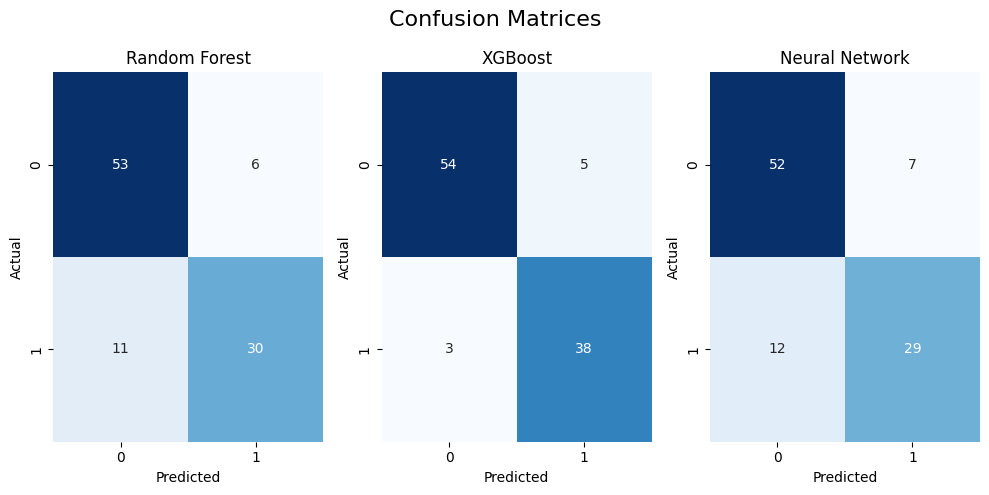

In [28]:
classifier_names = [
    'Random Forest',
    'XGBoost',
    'Neural Network'
]

fig, axes = plt.subplots(1, 3, figsize=(10,5))
fig.suptitle('Confusion Matrices', fontsize=16)

axes = axes.ravel()

for i, (cm, name) in enumerate(zip(
    [cm_rf,
    cm_xgb,
    cm_nn],
    classifier_names
)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## Results
The confusion matrices show that, because there were almost twice as many class 1 examples as class 0 (673 versus 340), both models learned to favor predicting class 1. As a result, they correctly label most positive cases (high true positives) but also misclassify some negatives as positives (false positives). There are still a few missed positives (false negatives), indicating that even with more class 1 data, neither model achieves perfect sensitivity. Overall, the imbalance drives a tendency to label uncertain cases as class 1, yielding strong positive recall at the cost of some precision on class 0.